In [1]:
# Users may need to execute the following to get the neural_network module

# ! git clone https://github.com/mkpro118/CS-539-project.git

# import sys
# sys.path.insert(0, 'CS-539-project')

In [2]:
# Load the data
import numpy as np

from data import load_data

data = load_data(depth_first=False)

X, y = data.data, data.labels
labels, names =  data.unique_labels, data.unique_label_names
input_shape = data.shape

print(f'X.shape      = {X.shape}')
print(f'y.shape      = {y.shape}')
print(f'labels.shape = {labels.shape}')
print(f'Label names  = {", ".join(names)}')

X.shape      = (651, 224, 224, 3)
y.shape      = (651,)
labels.shape = (5,)
Label names  = bishop, knight, pawn, queen, rook


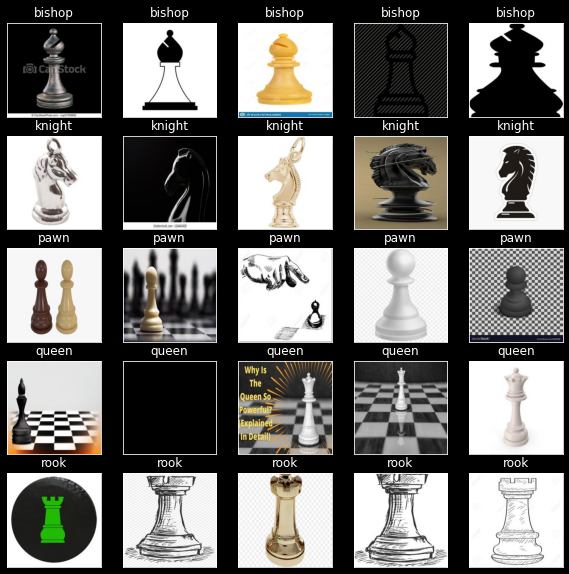

In [3]:
# Visualize the data
def sample(X, y, samples):
    unique_ys = np.unique(y, axis=0)
    result = []
    for unique_y in unique_ys:
        val_indices = np.argwhere(y==unique_y).flatten()
        random_samples = np.random.choice(val_indices, samples, replace=False)
        result.extend(map(lambda x:(x, unique_y), X[random_samples]))
    return result
    

_X = sample(X, y, 5)

%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('dark_background')

fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))
axs = axs.flatten()
for i, (ax, (a, b)) in enumerate(zip(axs, _X)):
    ax.imshow(a)
    ax.set_title(f'{names[i // 5]}')
    ax.tick_params(
        left=False,
        labelleft=False,
        labelbottom=False,
        bottom=False
    )

plt.show()

In [4]:
# Partition into train/test

from neural_network.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

print(f'X_train.shape = {X_train.shape}')
print(f'y_train.shape = {y_train.shape}')
print(f'X_test.shape  = {X_test.shape}')
print(f'y_test.shape  = {y_test.shape}')

X_train.shape = (550, 224, 224, 3)
y_train.shape = (550,)
X_test.shape  = (101, 224, 224, 3)
y_test.shape  = (101,)


In [5]:
# CV splitter

from neural_network.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=3)
cv_splitter = skf.split(X_train, y_train)

In [6]:
# One hot encode labels
from neural_network.preprocess import OneHotEncoder

encoder = OneHotEncoder().fit(labels)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

print(f'y_train.shape = {y_train.shape}')
print(f'y_test.shape  = {y_test.shape}')

y_train.shape = (550, 5)
y_test.shape  = (101, 5)


In [7]:
# Define the model

from keras.layers import Conv2D, Dense, Flatten, BatchNormalization
from keras.models import Sequential

net = Sequential()

net.add(Conv2D(filters=25, kernel_size=3, input_shape=data.shape, data_format='channels_last'))
net.add(Conv2D(filters=16, kernel_size=3))
net.add(Conv2D(filters=9, kernel_size=3))
net.add(Conv2D(filters=4, kernel_size=3))
net.add(Conv2D(filters=4, kernel_size=3))
net.add(Conv2D(filters=4, kernel_size=3))
net.add(Conv2D(filters=1, kernel_size=3))
net.add(Flatten())
net.add(Dense(256, activation='sigmoid'))
net.add(Dense(256, activation='tanh'))
net.add(Dense(128, activation='sigmoid'))
net.add(Dense(128, activation='sigmoid'))
net.add(Dense(32, activation='softmax'))
net.add(Dense(12, activation='tanh'))
net.add(Dense(10, activation='tanh'))
net.add(Dense(5, activation='softmax'))


net.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
for train, validate in cv_splitter:
    net.fit(
        X_train[train],
        y_train[train],
        epochs=50,
        batch_size=32,
        validation_data=(X_train[validate], y_train[validate])
     )

Epoch 1/50
12/12 [==============================] - 42s 3s/step - loss: 1.6102 - accuracy: 0.2514 - val_loss: 1.6045 - val_accuracy: 0.2663
Epoch 2/50
12/12 [==============================] - 44s 4s/step - loss: 1.6014 - accuracy: 0.2678 - val_loss: 1.5970 - val_accuracy: 0.2663
Epoch 3/50
12/12 [==============================] - 42s 4s/step - loss: 1.5955 - accuracy: 0.2678 - val_loss: 1.5921 - val_accuracy: 0.2663
Epoch 4/50
12/12 [==============================] - 42s 4s/step - loss: 1.5906 - accuracy: 0.2678 - val_loss: 1.5891 - val_accuracy: 0.2663
Epoch 5/50
12/12 [==============================] - 44s 4s/step - loss: 1.5882 - accuracy: 0.2678 - val_loss: 1.5873 - val_accuracy: 0.2663
Epoch 6/50
12/12 [==============================] - 44s 4s/step - loss: 1.5861 - accuracy: 0.2678 - val_loss: 1.5859 - val_accuracy: 0.2663
Epoch 7/50
12/12 [==============================] - 47s 4s/step - loss: 1.5844 - accuracy: 0.2678 - val_loss: 1.5849 - val_accuracy: 0.2663
Epoch 8/50
12/12 [==

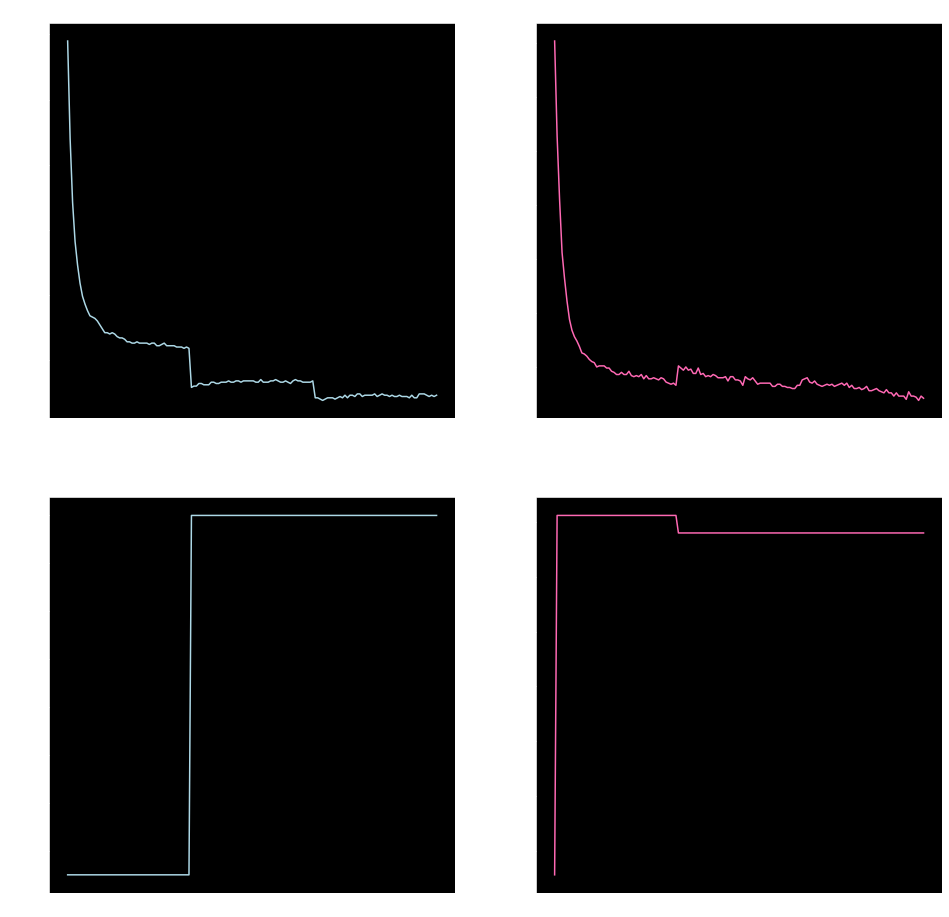

In [9]:
# We forgot to save the history for this model, 
# so the graphs have drawn by extracting data from the
# verbose output

loss = [data['loss'] for data in output]
accuracy = [data['accuracy'] for data in output]
val_loss = [data['val_loss'] for data in output]
val_accuracy = [data['val_accuracy'] for data in output]

epochs = np.arange(1, len(accuracy) + 1)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 16))

ax1.plot(epochs, val_loss, color='lightblue')
ax1.set_title("Validation Loss")
ax2.plot(epochs, loss, color='hotpink')
ax2.set_title("Overall Loss")

ax3.plot(epochs, val_accuracy, color='lightblue')
ax3.set_title("Validation Accuracy")
ax4.plot(epochs, accuracy, color='hotpink')
ax4.set_title("Overall Accuracy")

plt.show()